# Problem 1: Gradient-based variational inference

Let us consider the exact same model and data as in the previous exercise set:
\begin{align*}
x_n &\sim \text{Poisson}(uv),\\
u &\sim \text{Gamma}(6, 1),\\
v &\sim \text{Gamma}(3, 3).
\end{align*}
with the same data $\mathbf{x}=[5, 3, 9, 13, 5, 3, 5, 1, 2, 7, 6, 5, 6, 7, 4]$.

Now we use gradient-based methods to learn variational approximation for the posterior. 

Write code that:
1. Specifies the approximation using suitable pytorch.distribution
2. Evaluates the ELBO by using $M$ samples drawn from the approximation with .rsample()
3. Optimizes ELBO wrt the parameters of the approximation
4. Plots the approximation on top of Gibbs samples
5. Plots convergence of the ELBO estimate (note that with small $M$ this may be somewhat noisy). Use this plot to check that your optimizer actually has converged to a good solution.

Use the code to try out alternative models and approximations. For each of the three alternatives below, always show both the convergence curve and the resulting posterior approximation and **explain what you see**.
1. Use the same approximation family as before, so that $q(u,v)$ is a product of two gamma distributions. Do you get the same result as with CAVI?
2. Use multivariate normal approximation, so that $q(u,v)$ is a bivariate normal distribution. Explain what changed.
3. Change the prior $p(u,v)$ from product of two gamma distributions to product of two half-normal distributions with scales of your own choosing. Explain what happens.

HINTS:
1. https://pytorch.org/docs/stable/distributions.html helps with the distribution syntax etc.
2. You can use any $M$, but probably it is best to avoid very small ones. It is a good idea to quickly explore how the estimate behaves as a function of $M$.
3. The easiest way to parameterize the multivariate normal is to use some 2x2 matrix $A$ as learnable parameters but then give "L = torch.tril(A)" as the Cholesky parameter for the multivariate normal distribution. We have one extra parameter in $A$ that is never optimized or used (the top right corner), but that does not matter.
4. Be careful with bounds: You have positivity requirement for two things here, for the **parameters of the approximation terms** (for gamma approximation) and additionally for **the samples u and v drawn from the approximation** (for the normal approximation that could result in negative samples). You can, for example, use "torch.nn.functional.softplus(alpha_unconstrained)" as the alpha-parameter in a gamma distribution, and you can truncate the samples from the normal distribution to a small positive constant or push those also through softplus. The former is always valid but the latter is strictly speaking wrong as we then use truncated normal as approximation, but we can ignore this problem here for simplicity.
5. It is possible to write general code that directly supports arbitrary distributions, but that is quite tedious. You can definitely have separate copies of your code for the different choices of $q(u,v)$ if that is easier -- that's what I will be doing in model solutions anyway.
6. You already know the optimal solution for the gamma approximation based on Exercise 3. The values are quite large, so you might want to also initialize your approximation with numbers of similar magnitude to make the optimization problem a bit easier.

The cell below again has the model definition and Gibbs sampler for ease of result presentation.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

u_alpha = 6.
u_beta = 1.
v_alpha = 3.
v_beta = 3.

x = np.array([5,3,9,13,5,3,5,1,2,7,6,5,6,7,4])
N = len(x)

# Priors
u_prior = stats.gamma(u_alpha, scale=1./u_beta)
v_prior = stats.gamma(v_alpha, scale=1./v_beta)

def log_density(data, u, v):
    likelihood = stats.poisson(u*v)
    return np.sum(likelihood.logpmf(data)) + u_prior.logpdf(u) + v_prior.logpdf(v)

def Gibbs(x, u, v, T):
    # Storage for samples
    samples = [u, v]
    sumx = sum(x)
    N = len(x)
    for t in range(T):
        # Sample u conditional on v and data
        log_lambda_term = sumx + u_alpha
        lambda_term = N*v + u_beta
        u = np.random.gamma(log_lambda_term, scale = 1.0 / lambda_term)
        
        # Sample v conditional on u and data
        log_lambda_term = sumx + v_alpha
        lambda_term = N*u + v_beta
        v = np.random.gamma(log_lambda_term, scale = 1.0 / lambda_term)

        samples = np.vstack([samples, [u, v]])
    return samples

## Gamma product approximation

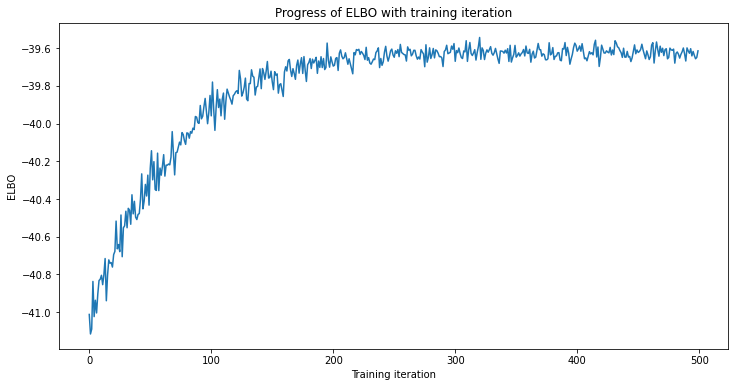

u mean estimate: 5.7741914
v mean estimate: 0.9421002


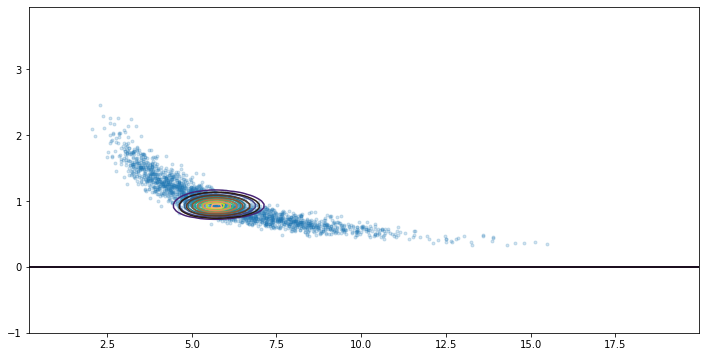

In [2]:
import torch
from torch.nn.functional import softplus as sp

# Define data and the optimization problem
data = torch.tensor(x).reshape((1, N))
parameters = torch.nn.Parameter(torch.tensor([86., 13., 87., 89.], requires_grad=True)) # Set also some initial values here
opt = torch.optim.Adam([parameters], lr=1e-2)
M = 1000
nIter = 500

# Priors
u_prior = torch.distributions.Gamma(u_alpha, u_beta)
v_prior = torch.distributions.Gamma(v_alpha, v_beta)

def log_density(data, u, v):
    likelihood = torch.distributions.Poisson(u*v)
    return torch.sum(likelihood.log_prob(data), axis=1) + u_prior.log_prob(u) + v_prior.log_prob(v)

ELBOS = list()
for i in range(nIter):
    opt.zero_grad()

    # Define approximation
    q_u = torch.distributions.Gamma(sp(parameters[0]), sp(parameters[1]))
    q_v = torch.distributions.Gamma(sp(parameters[2]), sp(parameters[3]))

    # Obtain samples
    u = q_u.rsample((M, 1))
    v = q_v.rsample((M, 1))
    
    # Compute ELBO
    ELBO = torch.mean( log_density(data, u, v) - (q_u.log_prob(u) + q_v.log_prob(v)) )
    
    # We need a minimization problem but ELBO is to be maximized
    loss = -ELBO
    loss.backward()
    ELBOS.append(ELBO.item())
    opt.step()


'''USING CAVI'''
# Iterative optimization of q_u and q_v

prior_alpha_u = 6
prior_beta_u = 1
prior_alpha_v = 3
prior_beta_v = 3

sum_x = x.sum()

# Definte the approximation
# Assume factorized q(mu,sigma) = q(mu|m,s) q(sigma|a,b) (normal and gamma)
# params for u: a, b
q_u_param_cavi = [prior_alpha_u + sum_x, 20.0]

# params for v: c, d
q_v_param_cavi = [prior_alpha_v + sum_x, 20.0]

q_u_cavi = stats.gamma(q_u_param_cavi[0], scale=1.0/q_u_param_cavi[1])
q_v_cavi = stats.gamma(q_v_param_cavi[0], scale=1.0/q_v_param_cavi[1])

# Perform optimization; note how few iterations are enough here
for iter in range(100):
    ### Update q_u
    # Compute required expectations
    E_v = q_v_cavi.mean()
    # If we were to implement the ELBO, we would also need the following expectation that is not
    # implemented in scipy.stats
    #E_log_prec = np.log(q_prec_param[1]) + scipy.special.digamma(q_prec_param[0])
    
    # Update the parameters
    q_u_param_cavi[1] = prior_beta_u + N*E_v
    q_u_cavi = stats.gamma(q_u_param_cavi[0], scale=1./q_u_param_cavi[1])
    
    ### Update q_v
    # Compute required expectations
    E_u = q_u_cavi.mean()
    
    # Update the parameters
    q_v_param_cavi[1] = prior_beta_v + N*E_u
    q_v_cavi = stats.gamma(q_v_param_cavi[0], scale=1./q_v_param_cavi[1])

    
# Plotting goes here
# 1. Convergence plot
# 2. Illustration of the posterior
plt.plot(ELBOS)
plt.title("Progress of ELBO with training iteration")
plt.xlabel("Training iteration")
plt.ylabel("ELBO")
plt.show()

# Mean estimates
u_me = u.mean()
v_me = v.mean()

# Convert to np for plotting
parameters = parameters.detach().numpy()
u_me = u_me.detach().numpy()
v_me = v_me.detach().numpy()

print("u mean estimate:", u_me)
print("v mean estimate:",v_me)

ugrid = np.arange(0.2,20,0.05)
vgrid = np.arange(-1,4,0.05)
uset, vset = np.meshgrid(ugrid, vgrid)

# For the plotting you can get the density with something like the following, assuming your q_u and q_v are common distributions
pdf_CAVI = (q_u_cavi.pdf(uset)*q_v_cavi.pdf(vset)).reshape(uset.shape)

# For the plotting you can get the density with something like the following, assuming your q_u and q_v are common distributions
pdf_VI = (stats.gamma(parameters[0], scale=1./parameters[1]).pdf(uset) * stats.gamma(parameters[2], scale=1./parameters[3]).pdf(vset)).reshape(uset.shape)

# # Add some Gibbs samples on top to compare
gibbs_samples = Gibbs(x, u_me, v_me, 2500)
plt.plot(gibbs_samples[500:,0], gibbs_samples[500:,1], '.', alpha=0.2)

# # Then plot the countours
_ = plt.contour(uset, vset, pdf_VI, levels=10, cmap="viridis")
_ = plt.contour(uset, vset, pdf_CAVI, levels=6, cmap="copper")

The Gradient VI was plotted with the Viridis colormap and the CAVI approximation was plotted with the copper colormap. We can see that both approximations lie pretty much on top of each other, spanning the same region. We may get a small deviation due to the involved stochasticity in using samples in the ELBO computation with gradient VI (though this should be mostly offset by the amount of samples we use), as well as the updates on the gradient depending on the learning rate (so it may hop around in a small region around the optimum). Considering this, we arrive to basically the same result, where we see that the majority of the mass is concentrated in a restricted region around the mean of the true distribution.

Note that we aren't able to capture "twisting" with the assumed model, since we are assuming a factorized prior over Gammas (which means that we are assuming no correlation between the samples of u and v). This means that we aren't able to give twists to this approximate distribution. Nonetheless we are able to get a reasonable approximate for the true mean (which was calculated for exercise set 3 at $u\approx 5.77$ and $v\approx 0.92$); the small offset could be due to the assumed uncorrelation and stochastic error, but we still get a value that is very close, so the VI approximation could work well for a range restricted around here.

## Multivariate normal approximation

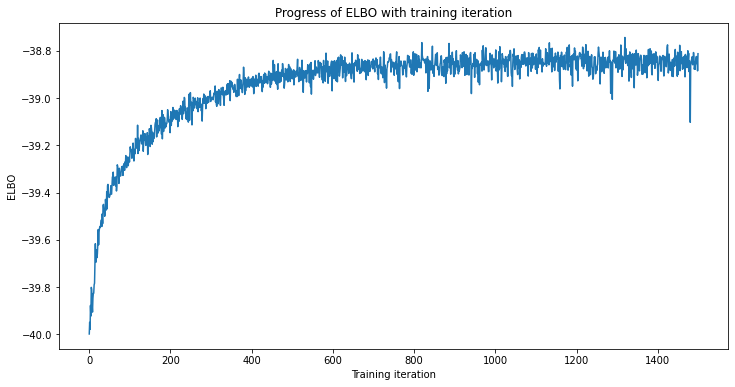

u mean estimate: tensor(5.7898, dtype=torch.float64)
v mean estimate: tensor(0.9634, dtype=torch.float64)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


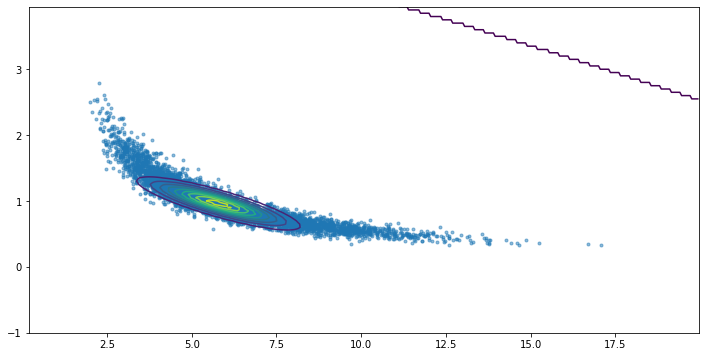

In [3]:
# Define data and the optimization problem
x = np.array([5,3,9,13,5,3,5,1,2,7,6,5,6,7,4])
N = len(x)
data = torch.tensor(x, dtype=torch.double).reshape((1, N))

u_gamma_mean = 6.
u_gamma_var = 0.5
v_gamma_mean = 0.9
v_gamma_var = 0.05
uv_gamma_cov = 0.

params = torch.nn.Parameter(torch.tensor([u_gamma_mean, v_gamma_mean, u_gamma_var, uv_gamma_cov, v_gamma_var], requires_grad=True, dtype=torch.double))
opt = torch.optim.Adam([params], lr=1e-3)
M = 500
nIter = 1500

# Priors
u_prior = torch.distributions.Gamma(u_alpha, u_beta)
v_prior = torch.distributions.Gamma(v_alpha, v_beta)

def log_density(data, u, v):
    likelihood = torch.distributions.Poisson(u*v)
    return torch.sum(likelihood.log_prob(data), axis=1) + (u_prior.log_prob(u) + v_prior.log_prob(v)).flatten()

ELBOS = list()
for i in range(nIter):
    opt.zero_grad()

    # Define approximation
    mu = params[:2]
    cov = torch.zeros((2, 2), dtype=torch.double)
    cov[torch.tril_indices(2, 2, offset=0).tolist()] = params[2:]
    # q_uv = torch.distributions.MultivariateNormal(params[0], scale_tril=torch.tril(params[1]))
    q_uv = torch.distributions.MultivariateNormal(mu, scale_tril=torch.tril(cov))

    # Obtain samples
    uv = torch.clamp(q_uv.rsample([M]), 1e-8)
    u = uv[:,0].reshape((M, 1))
    v = uv[:,1].reshape((M, 1))
    
    # Compute ELBO
    ELBO = torch.mean( log_density(data, u, v) - q_uv.log_prob(uv) )
    
    # We need a minimization problem but ELBO is to be maximized
    loss = -ELBO
    loss.backward()
    ELBOS.append(ELBO.item())
    opt.step()

# Plotting goes here
# 1. Convergence plot
# 2. Illustration of the posterior
plt.plot(ELBOS)
plt.title("Progress of ELBO with training iteration")
plt.xlabel("Training iteration")
plt.ylabel("ELBO")
plt.show()

# Convert to np for plotting
mu = params[:2].detach()

print("u mean estimate:", mu[0])
print("v mean estimate:", mu[1])

tril = torch.zeros((2, 2), dtype=torch.double)
tril[torch.tril_indices(2, 2, offset=0).tolist()] = params[2:].detach()

ugrid = torch.arange(0.2,20,0.05)
vgrid = torch.arange(-1,4,0.05)
uset, vset = torch.meshgrid(ugrid, vgrid)

pos = torch.dstack((uset, vset))
pdf_VI = torch.exp(torch.distributions.MultivariateNormal(mu, scale_tril=tril).log_prob(pos))

# Add some Gibbs samples on top to compare
gibbs_samples = Gibbs(x, mu[0], mu[1], 5500)
plt.plot(gibbs_samples[500:,0], gibbs_samples[500:,1], '.', alpha=0.5)

# Then plot the countours
_ = plt.contour(uset, vset, pdf_VI, levels=10, cmap="viridis")

In this case, since we are using a model that does assume covariance between the samples of u and v, we can add inclination to the distribution's orientation. This allows us to cover a wider region of the true model's distribution, giving us an arguably better representation of the true distribution compared to the double Gamma model. I say arguably because it's hard to visualize height with contour maps and scatter plots, so the double Gamma *may* be able to represent the vertical geometry better around the mean, but it's hard to tell with these visualizations. However, the Multivariate Normal approximation is able to give a bit of a better representations of the tails (not perfect of course, but still better than the factorized Gamma model since it is able to cover a wider range of values).

We can also see that, as is characteristic with Variational Inference approximations, the Multivariate Normal approximation is confined within the true model's range, since the KL divergence heavily penalizes distributions that are non-zero when the true distribution is zero. This puts a strong restriction over the region that the surrogate is allowed to cover. Nonetheless, we still get a reasonably good approximation to the true distribution's theoretical mean; the small offset could be both due to stochastic error as well as the previously mentioned height of the distribution, which may be better represented by the normal at this location.

## Multivariate normal approximation with half-normal prior

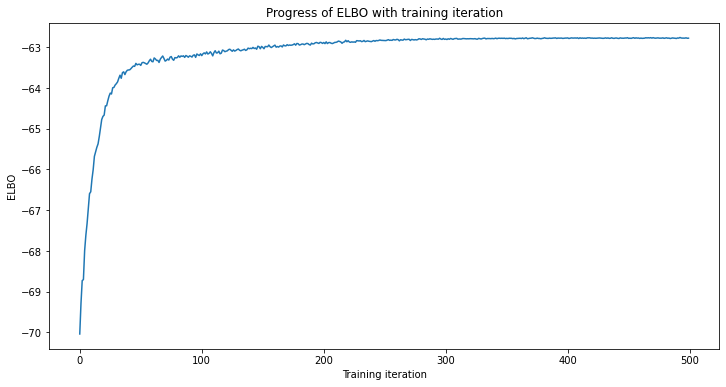

u mean estimate: tensor(4.9314, dtype=torch.float64)
v mean estimate: tensor(0.8040, dtype=torch.float64)


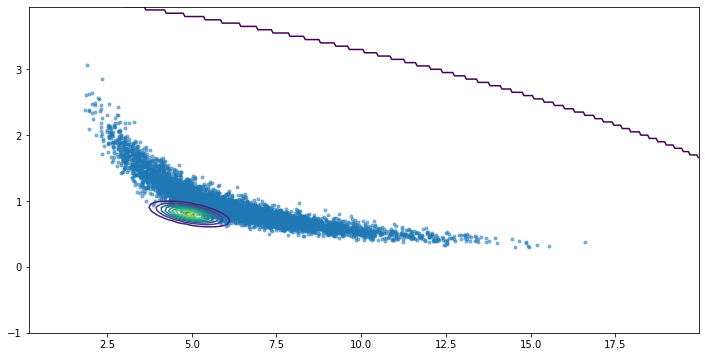

In [4]:
# Define data and the optimization problem
data = torch.tensor(x).reshape((1, N))

# Estimating mean and variance of the theoretical distributions for u and v
u_gamma_mean = 87./15.
u_gamma_var = 87./15.**2
v_gamma_mean = 84./90.
v_gamma_var = 84./90.**2
uv_gamma_cov = np.sqrt(u_gamma_var*v_gamma_var)

params = torch.nn.Parameter(torch.tensor([u_gamma_mean, v_gamma_mean, u_gamma_var, uv_gamma_cov, v_gamma_var], requires_grad=True, dtype=torch.double))
opt = torch.optim.Adam([params], lr=5e-3)
M = 1000
nIter = 500

# Priors

# From Wikipedia's Half-Normal distribution page, variance
u_prior_std = np.sqrt(u_gamma_var/(1 - 2/np.pi))
v_prior_std = np.sqrt(v_gamma_var/(1 - 2/np.pi))

u_prior = torch.distributions.HalfNormal(torch.tensor([u_prior_std]))
v_prior = torch.distributions.HalfNormal(torch.tensor([v_prior_std]))

def log_density(data, u, v):
    likelihood = torch.distributions.Poisson(u*v)
    return torch.sum(likelihood.log_prob(data), axis=1) + (u_prior.log_prob(u) + v_prior.log_prob(v)).flatten()

ELBOS = list()
for i in range(nIter):
    opt.zero_grad()

    # Define approximation
    mu = params[:2]
    cov = torch.zeros((2, 2), dtype=torch.double)
    cov[torch.tril_indices(2, 2, offset=0).tolist()] = params[2:]
    # q_uv = torch.distributions.MultivariateNormal(params[0], scale_tril=torch.tril(params[1]))
    q_uv = torch.distributions.MultivariateNormal(mu, scale_tril=torch.tril(cov))

    # Obtain samples
    uv = torch.clamp(q_uv.rsample([M]), 1e-8)
    u = uv[:,0].reshape((M, 1))
    v = uv[:,1].reshape((M, 1))
    
    # Compute ELBO
    ELBO = torch.mean( log_density(data, u, v) - q_uv.log_prob(uv) )
    
    # We need a minimization problem but ELBO is to be maximized
    loss = -ELBO
    loss.backward()
    ELBOS.append(ELBO.item())
    opt.step()
    
# Plotting goes here
# 1. Convergence plot
# 2. Illustration of the posterior
plt.plot(ELBOS)
plt.title("Progress of ELBO with training iteration")
plt.xlabel("Training iteration")
plt.ylabel("ELBO")
plt.show()

# Convert to np for plotting
mu = params[:2].detach()

print("u mean estimate:", mu[0])
print("v mean estimate:", mu[1])

tril = torch.zeros((2, 2), dtype=torch.double)
tril[torch.tril_indices(2, 2, offset=0).tolist()] = params[2:].detach()

ugrid = torch.arange(0.2,20,0.05)
vgrid = torch.arange(-1,4,0.05)
uset, vset = torch.meshgrid(ugrid, vgrid)

pos = torch.dstack((uset, vset))
pdf_VI = torch.exp(torch.distributions.MultivariateNormal(mu, scale_tril=tril).log_prob(pos))

# Add some Gibbs samples on top to compare
gibbs_samples = Gibbs(x, mu[0], mu[1], 5500)
plt.plot(gibbs_samples[500:,0], gibbs_samples[500:,1], '.', alpha=0.5)

# Then plot the countours
_ = plt.contour(uset, vset, pdf_VI, levels=10, cmap="viridis")

In this case, we can see that the estimated model is very bad at representing the true distribution. The estimated mean is pretty far-off from the theoretical value and we are only able to cover a very small region at the edge of the banana shape of the true distribution. This (moreso than the previous experiments) showcases the importance of picking good priors, as they encode our beliefs about a distribution, and they restrict the possible range of values that we are able to explore. By chopping off the normal distribution in half we aren't able to represent symmetry very well, so we end up fitting the model off to a side of the true distribution where we are able to at least describe the "downhill" part of the distribution. As such, we aren't able to give good approximates for the central part of the distribution, and this possibly exacerbates our issues with the tails.

# Problem 2: Variational autoencoder

The code below implements most parts of a **variational autoencoder for the MNIST digits data** and also downloads the data for you on the first run. We use two-dimensional representations (K=2) for ease of plotting, fully connected neural networks for all components of the model, and normal likelihood for simplicity. A better model using convolutional networks, higher-dimensional representations and more suitable likelihoods would follow the exact same general algorithm.

You are free to consult external sources (including ones that provide code) to understand the model better, but remember to mention what you looked at.

Complete the implementation by
1. Specifying the prior distribution of the latent variables as a normal distribution with zero mean and unit covariance
2. Compute the parameters of the approximation for the set of samples in the current mini-batch. Remember that the standard deviation has to be positive.
3. Form the actual approximation and obtain samples from it using .rsample()
4. Compute the ELBO, using normal likelihood with fixed standard deviation (obs_sigma). Since every data point is independent both in terms of the prior and the likelihood, it is probably easiest to write the expression for a single data point and then take the mean of those. By taking the mean instead of sum, you get numbers that are comparable over multiple batch sizes. Remember that our observations have D=784 dimensions and you need to sum over those in the log-likelihood part.

Then run the code and inspect how it works. You should be seeing ELBO improve and the mean reconstructions for the images should look somehow reasonable. If this is not the case, try to guess what is wrong and debug your code. You can also change the parameters (number of hidden layers etc) if you want to further improve the results.

In [5]:
import torch
import torch.nn as nn
import torchvision
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Set hyperparameters of the model and optimization
K = 2
obs_sigma = 0.1
batch_size = 100
numEpoch = 30
lr = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST data 
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=True)

# Prior distribution for latent variables
p_z = torch.distributions.MultivariateNormal(torch.zeros(K).to(device), torch.eye(K).to(device))

# Encoder and decoder specifications. Both are fully connected networks, so no CNN magic here
D = 28*28
H = 40
encoder_mu = nn.Sequential(nn.Linear(D,H), nn.ReLU(),
                           nn.Linear(H,H), nn.ReLU(),
                           nn.Linear(H,K,bias=True)).to(device)
encoder_sigma = nn.Sequential(nn.Linear(D,H), nn.ReLU(),
                              nn.Linear(H,H), nn.ReLU(),
                              nn.Linear(H,K,bias=True)).to(device)
decoder = nn.Sequential(nn.Linear(K,H), nn.ReLU(),
                        nn.Linear(H,H), nn.ReLU(),
                        nn.Linear(H,D,bias=True)).to(device)

# Optimize over parameters of all networks
params = list(encoder_mu.parameters()) + list(encoder_sigma.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

loglike_sigma = obs_sigma*torch.ones(D).to(device)

def log_likelihood(data, mu):
    return torch.distributions.Normal(mu, loglike_sigma).log_prob(data).sum(axis=1)

elbos = []
for i in tqdm(range(numEpoch)):
    batches = iter(train_loader)

    epochloss = 0.
    for j in range(len(batches)):
        optimizer.zero_grad()

        # Next batch of samples
        batch_data, batch_targets = next(batches)
        x = batch_data.reshape((batch_size,-1)).to(device)
    
        # Form parameters of approximation
        mu_approx = encoder_mu(x)
        sigma_approx = encoder_sigma(x)
        
        # Sample from approximation
        q_z_x = torch.distributions.MultivariateNormal(mu_approx, torch.diag_embed(torch.clamp(sigma_approx, 1e-8)))
        z = q_z_x.rsample([100])

        # Find mean parameters of observed data
        x_mean = decoder(z).mean(axis=0)
        # ELBO
        ELBO_for_one_point = log_likelihood(x, x_mean) + p_z.log_prob(z) - q_z_x.log_prob(z)
        loss = - torch.mean(ELBO_for_one_point)
        epochloss += loss
    
        loss.backward()
        optimizer.step()
    elbos.append( (-epochloss/len(batches)).cpu().detach().numpy() )

  0%|          | 0/30 [00:00<?, ?it/s]

Below you find code for making the plots you need. Feel free to improve the plots if you want to show something else, for example illustrate the variance of the representations.

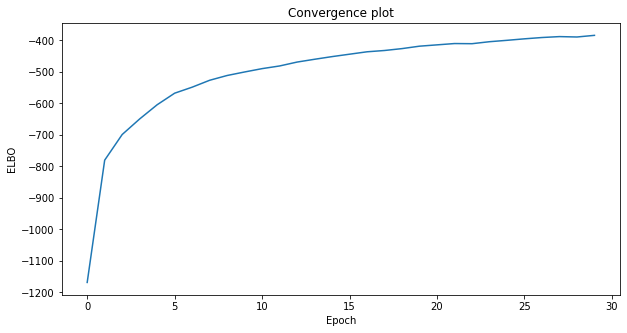

In [6]:
# Convergence plot
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(elbos)
plt.title("Convergence plot")
plt.xlabel('Epoch')
_ = plt.ylabel('ELBO')
plt.show()

The ELBO plot still shows a bit of possible growth, but it has tapered off so this starts to give us diminishing returns. Training more than 30 epochs in my system is pretty prohibitive, so I will present results at this point.

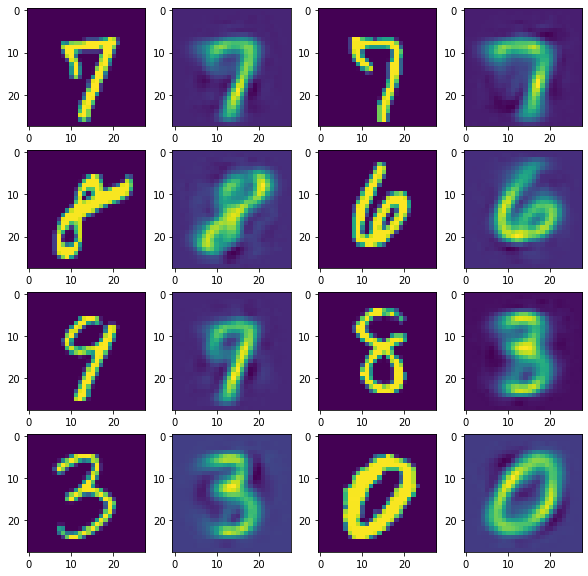

In [7]:
# Illustration of some samples, showing the mean of the reconstruction
plt.rcParams["figure.figsize"] = (10, 10)
# Note: Uses the values from the last iteration of the algorithm, so this shows some
# examples in the last minibatch
x = batch_data.reshape((batch_size,-1)).to(device)
for sam in range(8):
    plt.subplot(4,4,sam*2+1)
    plt.imshow(x[sam,:].cpu().reshape(28,28))

    plt.subplot(4,4,sam*2+2)
    plt.imshow(x_mean[sam,:].cpu().detach().reshape(28,28))
plt.show()
    
    
# 2D visualization of the data in the latent space
# Do this for 10,000 examples, forming a batch of those and computing q() for them
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=10000, shuffle=True)

batches_viz = iter(train_loader)
batch_data_viz, batch_targets_viz = next(batches_viz)
x_viz = batch_data_viz.reshape((10000,-1)).to(device)

We can see that the reconstructions that we get are pretty good overall, although there are some observations to do:

- The reconstructions are very blurry, which is what we had discussed during the lecture. Due to the normal distribution assumption in the latent space, we are able to get decently good mean approximations with blurry outputs.
- In some figures (like the 7 at the top left and the 8 at the bottom right, over the 0) we can see that the model is producing a bit of an uncertain output. The 7 reconstruction looks like it is close to becoming a 9, while the 8's reconstruction looks similar to a 3 because the left edges are blurrier than the rest. I think this is because we are compressing the 784-dimensional image space to a simple 2D Multivariate Normal in the latent space; we are compressing a lot of information, so we are bound to get some numbers to be close to each other. For example, 8 and 3 look relatively similar (some people draw 3 like a chopped version of 8), so they could be close to each other in the latent space. Similarly, the 7 on the top left has a big hook close to its vertical stick, which could make it closer to a 9 in the latent space.

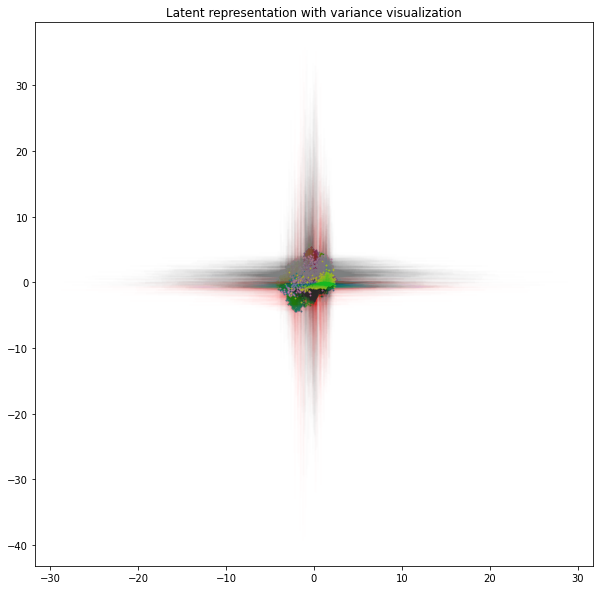

In [8]:
# Find the parameters of the approximation in the same way as during optimization
mu_approx = encoder_mu(x_viz)
sigma_approx = encoder_sigma(x_viz)

plt.rcParams["figure.figsize"] = (10, 10)
for c in range(10):
    plt.plot(mu_approx.cpu().detach()[batch_targets_viz==c,0], mu_approx.cpu().detach()[batch_targets_viz==c,1], '.', alpha=0.6, markersize=2.0)
    # Perhaps add here some way of illustrating the variance of the embedding
    #plt.plot(...)
    plt.errorbar(mu_approx.cpu().detach()[batch_targets_viz==c,0], mu_approx.cpu().detach()[batch_targets_viz==c,1], 
                xerr=sigma_approx.cpu().detach()[batch_targets_viz==c,0], yerr=sigma_approx.cpu().detach()[batch_targets_viz==c,1], alpha=5e-3)
    # plt.show()

plt.title("Latent representation with variance visualization")
plt.show()

I have tried to represent uncertainty in the latent space by using vertical and horizontal error bars that span 1 $\sigma$. I have the bars a very small alpha, this way if there are a lot of points that are close by and they overlap, we can see their concentration better around here. The main issue is that the variances we get are pretty big, so the final image looks a bit compressed. Nonetheless, we can have a relatively good idea of the uncertainty in the measurements by looking at the colors of the error bars and their density with this visualization. We could zoom in a bit more, or plot the mean values separately:

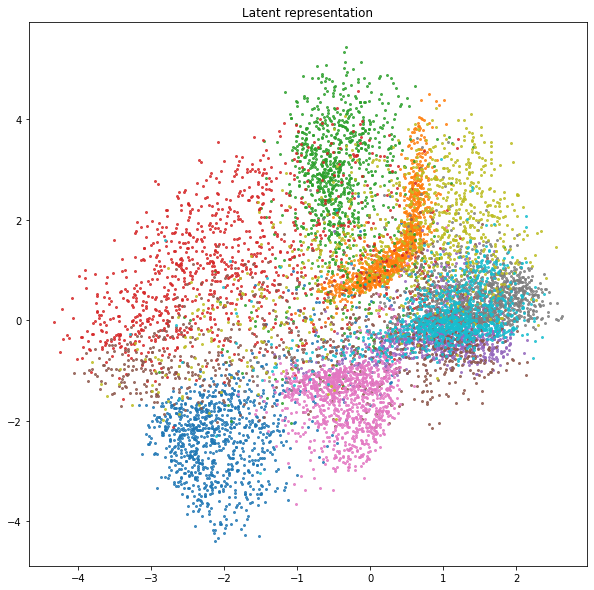

In [9]:
plt.rcParams["figure.figsize"] = (10, 10)
for c in range(10):
    plt.plot(mu_approx.cpu().detach()[batch_targets_viz==c,0], mu_approx.cpu().detach()[batch_targets_viz==c,1], '.', alpha=0.8, markersize=4.0)
    # Perhaps add here some way of illustrating the variance of the embedding
    #plt.plot(...)
    # plt.show()

plt.title("Latent representation")
plt.show()

I would have liked to get this visualization to something closer to the biorxiv paper we saw in class for the latent space representation of bird songs, but I feel like it would be a decent time sink. Since the latent space is inferred from observations, it's hard to tell what corresponds to what from the dataset, but we can still infer some things. For example, the cyan dots overlap a lot with the purple dots, which tells us that two numbers in the dataset tend to be drawn pretty similarly (possibly 3 and 8, or 1 and 7). There is a lot of mixing at the edges of each group, which can be due to unclear drawings from people (I have seen people draw a 1 that really resembles a 7 a lot, for example).

# Problem 3: Normalizing flows as variational approximation

Read through the paper "Sylvester Normalizing Flows for Variational Inference" by van den Berg et al. (UAI, 2018) available at http://auai.org/uai2018/proceedings/papers/156.pdf and watch the 15-minute conference precentation explaining the paper available at https://www.youtube.com/watch?v=VeYyUcIDVHI&ab_channel=UAI2018. Note that this is not the first paper tha proposed using normalising flows for variational inference, but I chose this because it is easier to read and understand.

Answer to the following questions. If you use the notebook to write the answers, please use the 'Markdown' mode for the cell and write equations in latex notation inside dollar symbols. Hand-written answers are also fine, and illustrations that help understand the concepts are appreciated.
1. Explain briefly **how the Sylvester flow works** -- explain it also using mathematical notation and tell the main characteristics. No need to go through any proofs or the details for different special cases, but focus on explaining the main principle.
2. Tell how we can **use the flow as variational approximation**, explaning it in words while also providing the details. You can either describe the details mathematically or write python-like pseudocode where you explain how specific quantities are being transformed and what do we optimize for etc.
3. What do you think the result would be if you applied this for our gamma-Poisson problem studied throughout the exercises? What would the resulting posterior approximation most likely be? Do you see challenges in using this for that problem?

In [4]:
import matplotlib.image as mpimg
# Function to introduce the mathematical derivations
def show_img(path):
    img = mpimg.imread(path)

    plt.figure(figsize = (20,20))
    plt.imshow(img)
    return

NOTE: All visualizations and mathematical expressions are taken from the provided paper.

In generative modelling, we try to learn a distribution $p_{\theta}(\mathbf{x}, \mathbf{z})$ with parameters $\mathbf{\theta}$, observations $\mathbf{x}$ and $D$-dimensional latent variables $\mathbf{z}$. A step in the process to find such a distribution is the marginalization of $p_{\theta}(\mathbf{x}|\mathbf{z})$ over $\mathbf{z}$ to find the prior, and this typically involves an intractable integral. In this course we have seen that Variational Inference (VI) is a method to find a surrogate distribution $q_{\phi}(\mathbf{z}|\mathbf{z})$ with learnable parameters $\mathbf{\phi}$, which we use to approximate the joint distribution through the optimization of the ELBO.

One of the most common distributions used for VI is the Gaussian distribution with correlation (as stated in the paper), but in some applications this may be too simple of an approximation for the latent space. The main problem is that since the ELBO is just a lower bound on the marginal likelihood, it could be loose and not represent the geometry of the target distribution very well. This results in the estimate possibly having a maximum located in a different place than the true distribution's, as illustrated by van den Berg et. al with an estimate $\hat{\theta}$ on the variational free energy $\mathcal{F}$, and a true maximum $\theta^*$ on a density $\log p(\mathbf{x})$


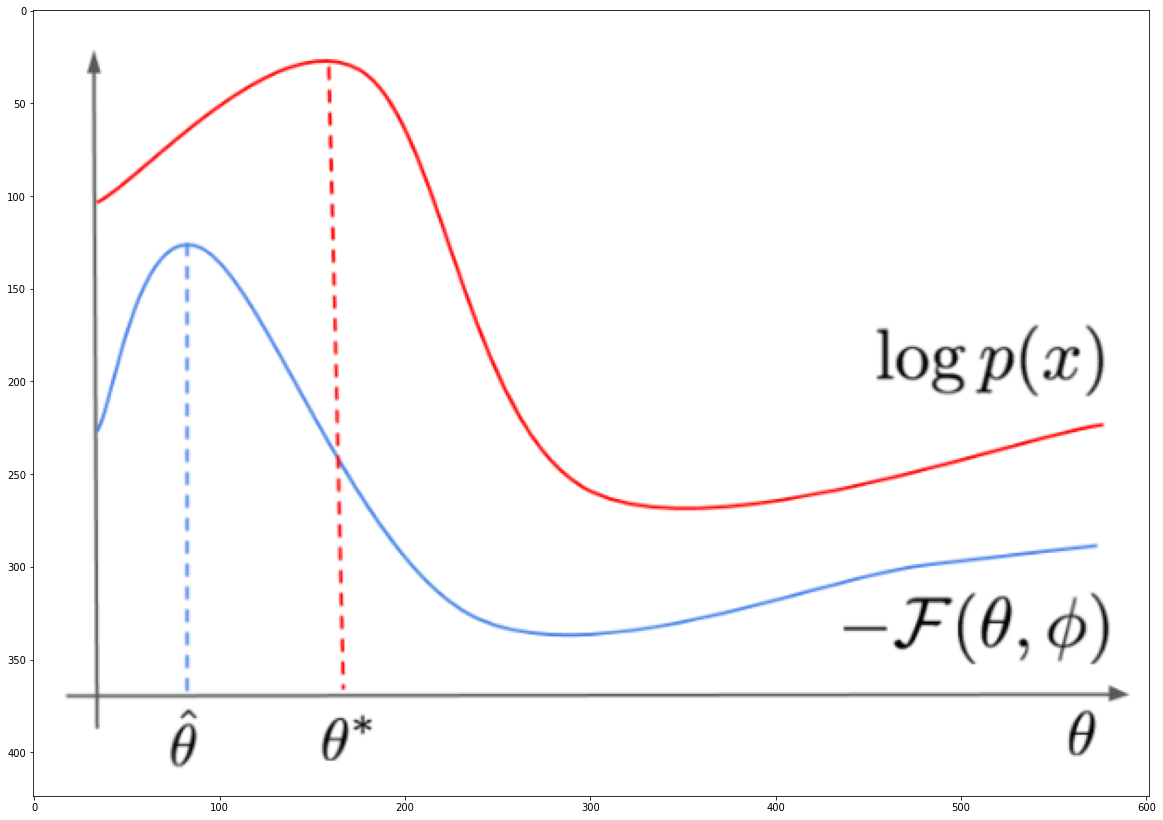

In [5]:
show_img("img/elbo_suboptimal.png")

As such, it is desirable to be able to generate more flexible distributions for the approximation. Normalizing Flows are an approach to produce such distributions. We have seen that the main idea to generate such distributions is to apply a sequence of invertible transformations $f_1,\ldots, f_k$ on a base distribution $p_0(\mathbf{z})$, which is typically a diagonal gaussian $\mathscr{N}\left(\mathbf{z}_0 | \mathbf{\mu}(\mathbf{x}), \mathbf{\sigma}^2(\mathbf{x})\right)$. The result of one such transformation is:

$$p_1(\mathbf{z}') = p_0(\mathbf{z})\left| \det\left( \frac{\partial f (\mathbf{z})}{\partial \mathbf{z}} \right) \right|^{-1}$$

Where $\mathbf{z}' = f(\mathbf{z})$ and $f : \mathbb{R}^D \mapsto \mathbb{R}^D$. In general, if we have a composition of functions $\mathbf{z}_K = f_K \circ \cdots \circ f_1 (\mathbf{z}_0)$ we have:

$$\log q_K (\mathbf{z}_K | \mathbf{x}) = \log q_0(\mathbf{z}_0 | \mathbf{x}) - \sum_{k=1}^{K} \log  \left| \det \left( \frac{ \partial f_k (\mathbf{z}_{k-1} ; \lambda_k (\mathbf{x}) }{\partial \mathbf{z}_{k-1}} \right) \right|$$

Where $\lambda_k$ denotes the parameters of the $k$-th transformation. The main challenge in using this technique is the cost of calculating the determinant of the Jacobian, which in general is $O(D^3)$. There are some approaches to make this computation less expensive; one presented in the paper is planar flows, where we use the following transformation:

$$\mathbf{z}' = \mathbf{z} + \mathbf{u}h\left( \mathbf{w}^{\intercal}\mathbf{z} + b \right)$$

where $\mathbf{w}, \mathbf{u} \in \mathbb{R}^{D}$, $b \in \mathbb{R}$ and $h(\cdot)$ is a smooth activation function; this sort of transformation is invertible as long as $\mathbf{u}^{\intercal}\mathbf{w} \geq 1$. The determinant of the Jacobian with such a transformation is given by the Matrix determinant lemma:

$$\det \frac{\partial \mathbf{z'}}{\partial \mathbf{z}} = \det (\mathbf{I} + \mathbf{u}h'(\mathbf{w}^{\intercal}\mathbf{z} + b)\mathbf{w}^{\intercal} ) = 1 + \mathbf{u}^{\intercal}h'(\mathbf{w}^{\intercal}\mathbf{z} + b)\mathbf{w} $$

where $h'(\cdot)$ is the derivative of $h(\cdot)$, which can be calculated in $O(D)$. Such a transformation can be interpreted as the application of a neural network with a single hidden unit that looks like the following:

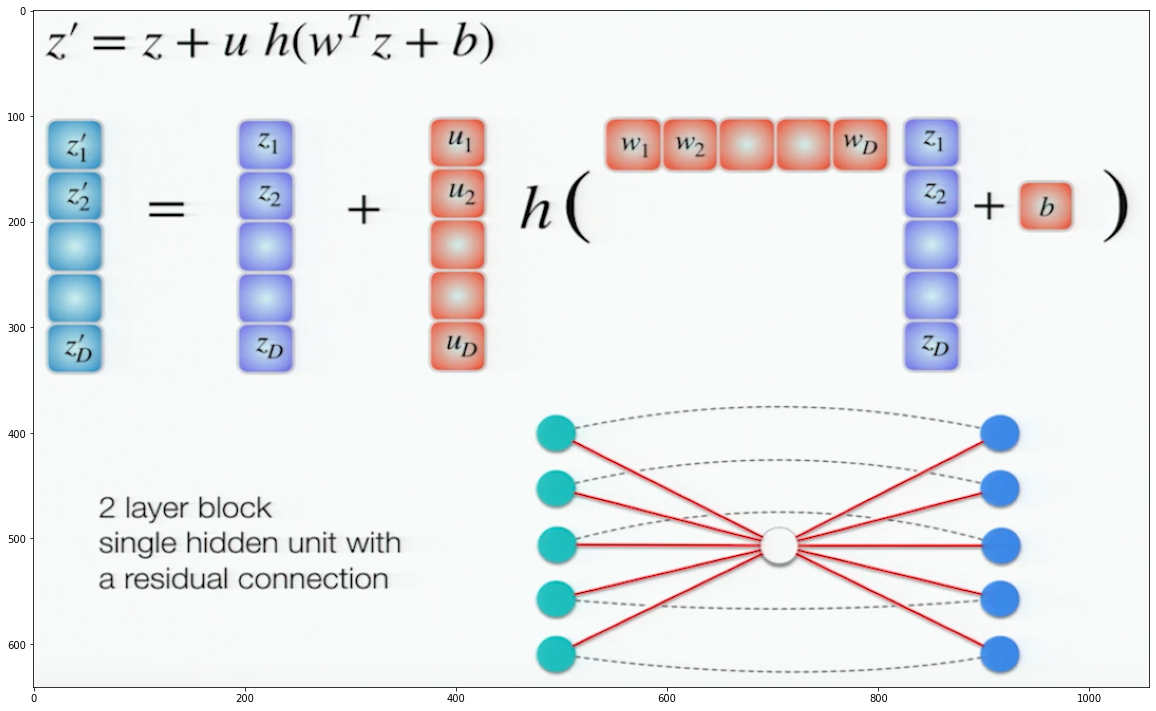

In [6]:
show_img("img/planar_nn.png")

As stated in the paper, the use of a single unit is a computational bottleneck because we're limited to computing a deformation in a single dimension, so we would need many more consecutive layers to represent a transformation, which requires more computation. We can generalize the idea of planar flows by switching the learnable vectors $\mathbf{u}$ and $\mathbf{w}$ for matrices $\mathbf{A} \in \mathbb{R}^{D\times M}$ and $\mathbf{B}\in \mathbb{R}^{M\times D}$, as well as generalizing the bias $b$ to a vector of length $M$ where $M \leq D$, which converts our neural network representation as follows:

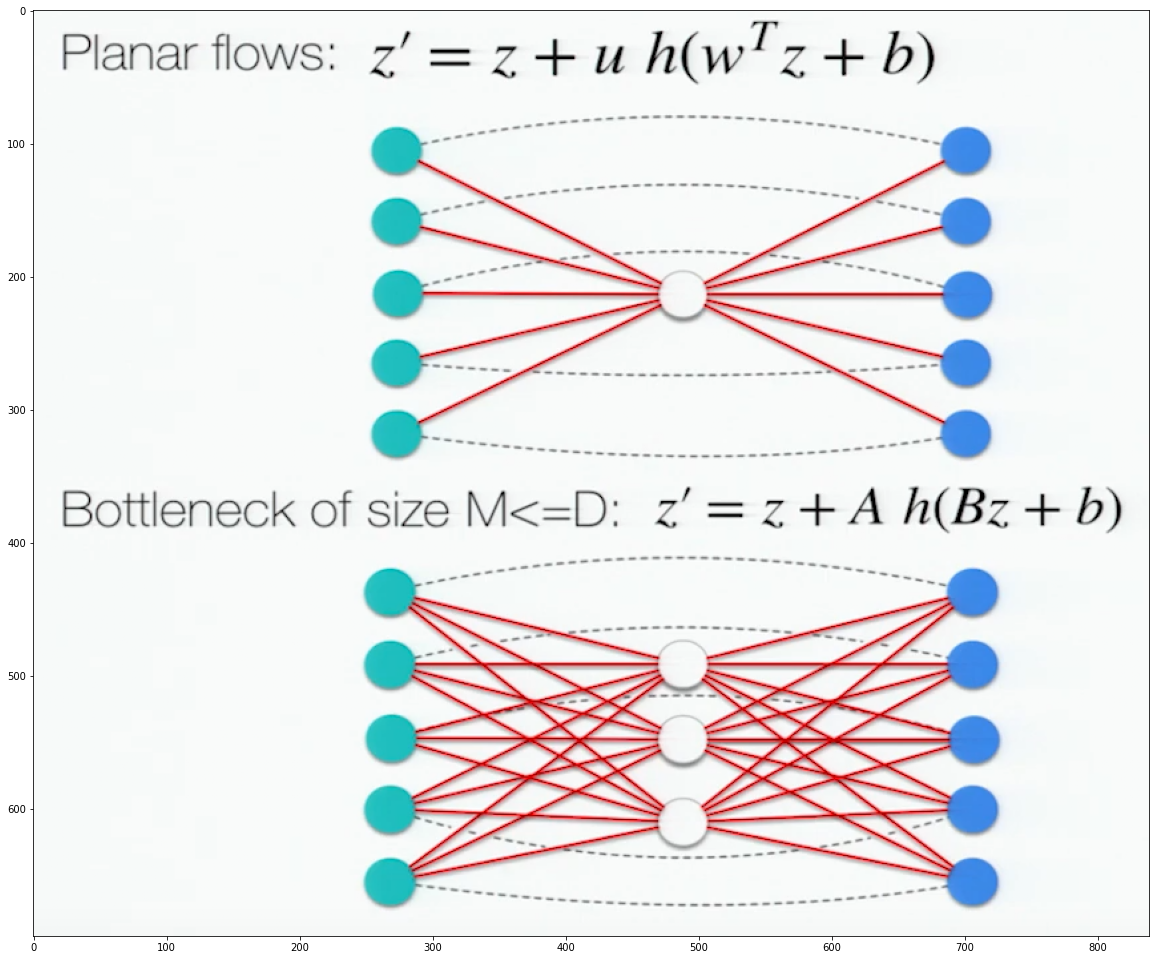

In [7]:
show_img("img/matrix_nn.png")

This makes our neural network representation more flexible, allowing us to learn more parameters per layer, which reduces the depth of the network and, in turn, reducing the amount of sequential computations required. The central idea behind Sylvester Normalizing Flows (SNFs) comes from the Sylvested determinant identity, which states that:

$$ \det(\mathbf{I}_D + \mathbf{A}\mathbf{B}) = \det(\mathbf{I}_M + \mathbf{B}\mathbf{A}) $$

For any matrices $\mathbf{A}$ and $\mathbf{B}$ with dimensions as specified before. This makes it so that, when $M < D$, the cost of calculating the determinant of an $D\times D$ matrix reduces to the cost of calculating the determinant for an $M\times M$ matrix. The dimension $M$ is a hyperparameter specified by us.

From here, what is left to define is how to specify the parametrization of the matrices $\mathbf{A}$ and $\mathbf{B}$. In the paper the proposed method is by using a QR decomposition, which has a nice property for computation. Using such a decomposition we have:

$$\mathbf{z}' = \mathbf{z} + \mathbf{QR}h\left(\mathbf{\tilde{R}Q^{\intercal}z} + \mathbf{b}\right)$$

where $\mathbf{Q}$ is orthogonal and $\mathbf{R}, \mathbf{\tilde{R}}$ are upper triangular. With these characteristics, the determinant of the jacobian becomes (by Sylvester's determinant identity):

$$\det \left(\mathbf{I}_{M} + \text{diag}\left(h'\left( \mathbf{\tilde{R}Q^{\intercal}z} + \mathbf{b} \right)  \right) \mathbf{\tilde{R}R} \right)$$

This determinant can be calculated in $O(M)$, because $\mathbf{\tilde{R}R}$ is upper triangular, so its determinant is just the multiplication of all the elements on its main diagonal. The paper also goes over three methods to estimate the matrices that we're interested in, all preserving the orthogonality of $\mathbf{Q}$, but these aren't as central to the method so I won't go in-depth giving an explanation about how they work.

Now we know that Normalizing Flows are a way to approximate some complex density function through a sequence of invertible transformations, which effectively corresponds to learning a neural network to estimate the function. We also saw that the main idea behind Sylvester Normalizing Flows is using Sylvester's determinant identity to reduce the complexity of the computation of the Jacobian determinant from $O(D^3)$ to $O(M^3)$, and if we learn the matrices that we're interested in with a $\mathbf{QR}$ decomposition, then it can go down to $O(M)$.

From here, it is relatively straightforward to see how we could use SNFs in variational inference, particularly after we learned about VAEs. We can follow this sequence of steps:

1. Sample $\mathbf{z} \sim p_0(\mathbf{z})$ for some prior $p_0$, e.g. a correlated Normal
2. Compute $\mathbf{z}'$ with the established sequence of transformations given by the neural network
3. Compute the joint log-density of the batch $\log p(\mathbf{z}', \mathbf{x}) = \log p(\mathbf{z}'|\mathbf{x}) + \log p_0(\mathbf{z})$.
4. Compute the log-likelihood of the approximate posterior (given by the normalizing flow) $\log q(\mathbf{z}'|\mathbf{x}) = \log p_0(\mathbf{z}) + \sum_{k=1}^{K}\det(\mathbf{J})$, where $\mathbf{J}$ is the Jacobian matrix as defined before
5. Optimize the ELBO with these quantities through gradient descent

This should give a tighter ELBO estimate when using Normalizing Flows.

### How can we use this on the Gamma-Poisson model?

As we have seen so far with the Gamma-Poisson model with simpler approximations (Gamma-multiplication and Normal distribution), the resulting approximations with VI end up being confined to a small region around the mean of the true distribution. This ends up with us not being able to capture the whole banana-like geometry of the true distribution, heavily misrepresenting the tails in the final approximation. By using a Normalizing Flow to define the approximate distribution, due to it being a model with considerably more flexibility, we would be able to fit the intricacies of the true distribution better, e.g. by capturing a "bendier" density.

There are some caveats with this statement. First, the Normalizing Flow can potentially have way more hyperparameters to optimize than the simple approximations we have used so far, due to the parameters $\lambda_k$ we have to learn for each transformation. This leads to a second problem: overfitting. If we are not careful with our tuning, we can grossly overfit our approximation to the observations we have. More in general, since we are training a Neural Network, a very non-trivial issue that can affect our results is if we are able to specify as many parameters as we would like (or even require for an accurate representation) with just the observations we have in the first exercise. This is a low-dimensional problem, so maybe all these problems won't blow up horribly, but it can still lead to a headache if we try to overspecify our model with too many transformations.